

# Object detection with Intel® Distribution of OpenVINO™ toolkit

This tutorial uses a Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model to walk you through the basic steps of using two key components of the Intel® Distribution of OpenVINO™ toolkit: Model Optimizer and Inference Engine.

Model Optimizer is a cross-platform command-line tool that takes pre-trained deep learning models and optimizes them for performance/space using conservative topology transformations. It performs static model analysis and adjusts deep learning models for optimal execution on end-point target devices.

Inference is the process of using a trained neural network to interpret data, such as images. This lab feeds a short video of cars, frame-by-frame, to the Inference Engine which subsequently utilizes an optimized trained neural network to detect cars.





    
## Part 1: Optimize a deep-learning model using the Model Optimizer (MO)

In this section, you will use the Model Optimizer to convert a trained model to two Intermediate Representation (IR) files (one .bin and one .xml). The Inference Engine requires this model conversion so that it can use the IR as input and achieve optimum performance on Intel hardware.


### 1. Importing Dependencies

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from openvino.inference_engine import IEPlugin, IENetwork
import cv2
# For labeling the image
from out_process import placeBoxes

Now, using the model downloader tool we will download the required models that are helpful in this exercise. We will use the **MobileNet-SSD** model. Download the model, specifying the name and output directory.

In [2]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models


###############|| Downloading topologies ||###############

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt
... 100%, 28 KB, 64918 KB/s, 0 seconds passed

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22749 KB/s, 0 seconds passed


###############|| Post processing ||###############




    
### 2. Run the Model Optimizer on the pretrained Caffe* model. This step generates one .xml file and one .bin file and place both files in the tutorial samples directory (located here: /object-detection/)

In [3]:
! python3 mo_caffe.py --input_model models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o models/object_detection/common/mobilenet-ssd/FP32 --scale 256 --mean_values [127,127,127]

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28225/Reference-samples/11oct/smart-video-workshop/object-detection/devcloud/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28225/Reference-samples/11oct/smart-video-workshop/object-detection/devcloud/models/object_detection/common/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specific parameters:
	- Enable resnet optimization:



   Note: Although this tutorial uses Single Shot MultiBox Detector (SSD) on a trained mobilenet-ssd* model, the Inference Engine is compatible with other neural network architectures, such as AlexNet*, GoogleNet*, MxNet* etc.


The Model Optimizer converts a pretrained Caffe* model to make it compatible with the Intel Inference Engine and optimizes it for Intel® architecture. These are the files you would include with your C++ application to apply inference to visual data.

   Note: if you continue to train or make changes to the Caffe* model, you would then need to re-run the Model Optimizer on the updated model.

### 3. Navigate to the tutorial sample model directory and verify creation of the optimized model files (the IR files)

In [4]:
!ls models/object_detection/common/mobilenet-ssd/FP32/

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml



    
You should see the following two files listed in this directory: mobilenet-ssd.xml and mobilenet-ssd.bin


## Part 2: Use the mobilenet-ssd* model and Inference Engine in an object detection application


### 1. Open the sample app [tutorial1.py](tutorial1.py)  and view the lines that call the Inference Engine.


    
-   Line 72 — Plugin initialization for specified device and load extensions library if specified
-   Line 77 — initializes the network object
-   Line 98 — Loading IR to the plugin...
-   Line 102 — Read and pre-process input image
-   Line 177 — allocate output blobs


### 3. Source your environmental variables

In [5]:
! /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


In [6]:
os.environ["VIDEO"] = "cars_1900.mp4"


    
### 4. Run the sample application to use the Inference Engine on the test video

The below script runs the application with different hardware availabe in devcloud. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

In [8]:
%%writefile object_detection_end2end.sh

ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 tutorial1.py                        -m models/object_detection/common/mobilenet-ssd/${FP_MODEL}/${NN_MODEL}  \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS \
                                            -ce /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION

Overwriting object_detection_end2end.sh




   Note: If you get an error related to "undefined reference to 'google::FlagRegisterer...", try uninstalling libgflags-dev: sudo apt-get remove libgflags-dev

### 6. Display output

For simplicity of the code and in order to put more focus on the performance number, video rendering with rectangle boxes for detected objects has been separated from main.cpp.

In [9]:
#Submit job to the queue
job_id_core = !qsub object_detection_end2end.sh -l nodes=1:idc001skl:i5-6500te -F "-r results/Core -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/Core', 'post_progress.txt', "Rendering", 0, 100)

59691.c003



    
You should see a video play with cars running on the highway and red bounding boxes around them.

Here are the parameters used in the above command to run the application:

In [10]:
videoHTML('IEI Tank (Intel  CPU)', 
          ['results/Core/output.mp4'])


    
## Part 3: Run the example on different hardware



    
### 1. CPU

In [11]:
#Submit job to the queue
job_id_core = !qsub object_detection_end2end.sh -l nodes=1:idc001skl:i5-6500te -F "-r results/Core -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/Core', 'post_progress.txt', "Rendering", 0, 100)

59693.c003



    
You will see the total time it took to run the inference.

#### 2. GPU

Since you installed the OpenCL™ drivers to use the GPU, you can run the inference on GPU and compare the difference.

Set target hardware as GPU with -d GPU

In [12]:
#Submit job to the queue
job_id_gpu = !qsub object_detection_end2end.sh -l nodes=1:idc001skl:intel-hd-530 -F "-r results/GPU -d GPU -f FP32 -i $VIDEO -n 4" -N obj_det_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/GPU', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/GPU', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/GPU', 'post_progress.txt', "Rendering", 0, 100)

59694.c003


In [14]:
videoHTML('IEI Tank (Intel Core GPU)', 
          ['results/GPU/output.mp4'] 
          )


    
The total time between CPU and GPU will vary depending on your system.

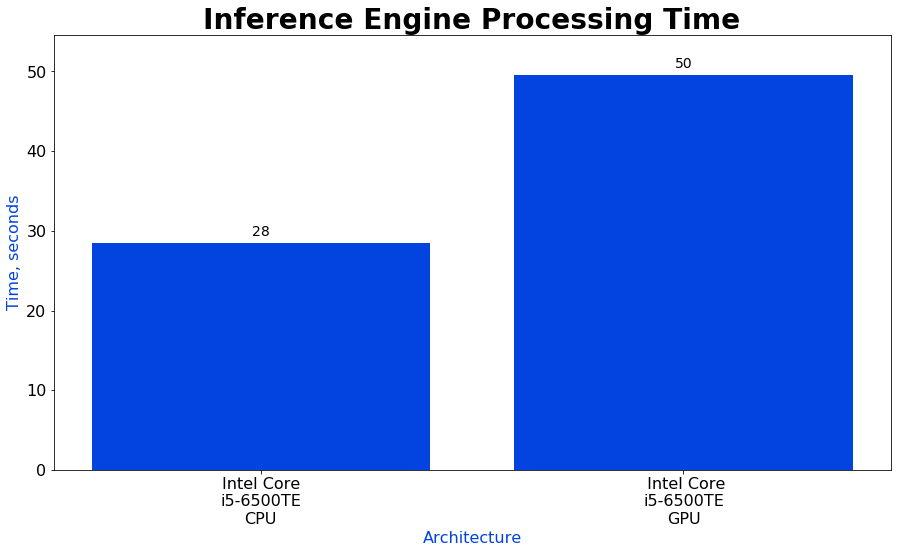

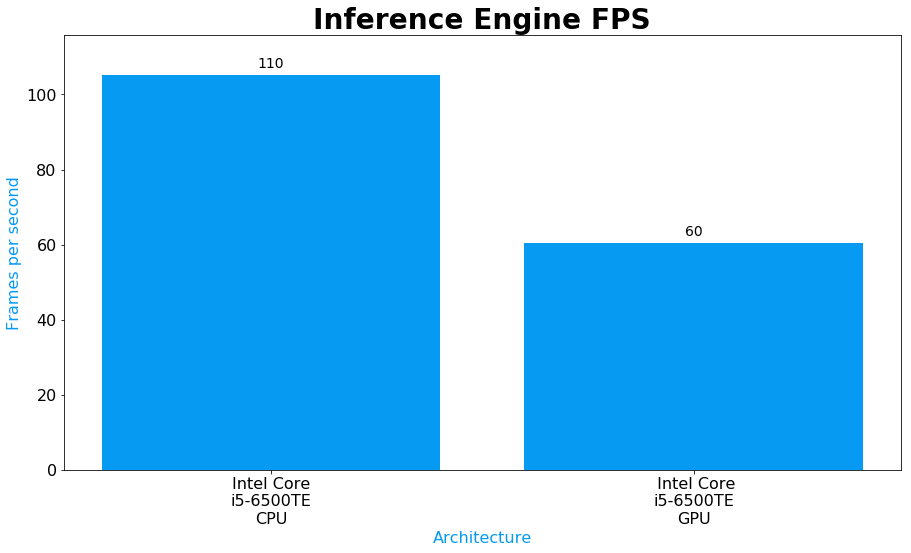

In [7]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/{arch}/stats.txt'.format(arch=arch), a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )